In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import numpy as np
np.random.seed(42)
import os
import pickle
import pandas as pd
parent_dir = os.path.abspath("../../")
sys.path.append(parent_dir)
parent_dir = os.path.abspath("../../utils/")
sys.path.append(parent_dir)

## Analysis

$\phi(\boldsymbol{u})$ is a random feature map for $\boldsymbol{u} \in \mathbb{R}^d$. For $\boldsymbol{Q'}, \boldsymbol{K'} \in \mathbb{R}^{L \times r}$ with rows given as  $\phi(\boldsymbol{q_i}^T)^T$ and $\phi(\boldsymbol{k_i}^T)^T$ respectively, leads to the more efficient attention mechanism of the form:
 $$
\begin{aligned}
  &\mathrm{Att}_{\!\leftrightarrow}(\mathbf{Q},\mathbf{K},\mathbf{V})
   = \hat{\mathbf{D}}^{-1}\bigl(\mathbf{Q}'((\mathbf{K}')^{\!\top}\mathbf{V})\bigr),
  &
  &\hat{\mathbf{D}}
   = \operatorname{diag}\!\bigl(\mathbf{Q}'((\mathbf{K}')^{\!\top}\mathbf{1}_L)\bigr).
\end{aligned}
$$

In the paper, they choose: 
$$\phi(\mathbf{x}) = \frac{h(\mathbf{x})}{\sqrt{m}} \left(f_1(\omega_1^T \mathbf{x}), \dots, f_1(\omega_m^T \mathbf{x}), ..., f_l(\omega_1^T \mathbf{x}), ..., f_l(\omega_m^T \mathbf{x})\right)$$

Here are 3 possible combinations to try:
1. $$\hat{SM_{m}}^{trig} (\mathbf{x}, \mathbf{y}) := h(x) = exp\left(\frac{\|\mathbf{x}\|^2}{2}\right), l=2, f_1 = sin, f_2 = cos$$
2. $$\hat{SM_{m}}^{+} (\mathbf{x}, \mathbf{y}) := h(x) = exp\left(-\frac{\|\mathbf{x}\|^2}{2}\right), l=1, f_1 = exp$$
3. $$\hat{SM_{m}}^{hyp+} (\mathbf{x}, \mathbf{y}) := h(x) = \frac{1}{\sqrt{2}}exp\left(-\frac{\|\mathbf{x}\|^2}{2}\right), l=2, f_1 = exp(u), f_2 = exp(-u)$$


How to choose $w_i$'s such that it is orthogonal:
We want to choose different random samples $\omega_1,...,\omega_m$ such that they come from $D \sim \mathcal{N}(0, \mathbf{I_d})$. We can use the Gram-Schmidt orthogonalisation to generate these. 


In [4]:
from FAVORAttentionHead import FAVORMultiHeadAttention

In [18]:
L = 128   # Sequence length / Batch size
d = 64   # Embedding dimension
m = d  # Number of random features
B = 2
n_heads = 8
MHFA = FAVORMultiHeadAttention(n_heads=8, d_model=d, dk=d//n_heads, dv=d//n_heads, m_features=m, kernel_type="+")

In [44]:
Q = torch.randn(B, L, d, device="cuda" if torch.cuda.is_available() else "cpu")
K = torch.randn(B, L, d, device="cuda" if torch.cuda.is_available() else "cpu")
V = torch.randn(B, L, d, device="cpu")

res = MHFA(Q, K, V, mask=None, return_attention=True)

In [45]:
res.shape, MHFA.attention_scores.shape, MHFA.queries.shape, MHFA.keys.shape

(torch.Size([2, 128, 64]),
 torch.Size([2, 8, 128, 128]),
 torch.Size([2, 8, 128, 64]),
 torch.Size([2, 8, 128, 64]))

<Axes: >

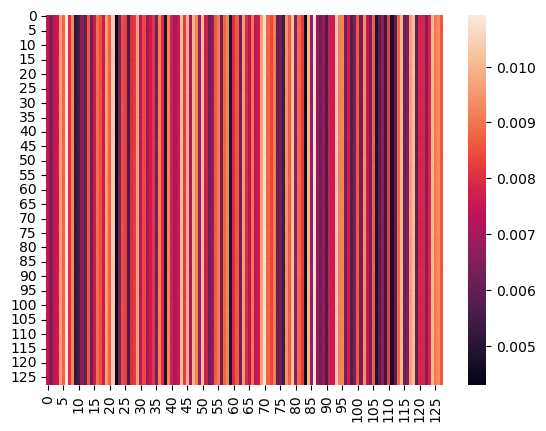

In [51]:
import seaborn as sns
sns.heatmap(MHFA.attention_scores[0, 7, :, :].detach().numpy())

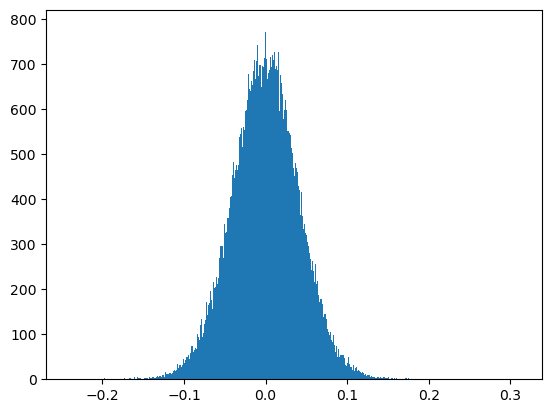

In [71]:
plt.hist((torch.tensor(favor_output, dtype=torch.float32) - regular_attention_output).reshape(-1), bins=1000);